# RL

In [1]:
## first, import the libraries we are going to use

import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from collections import namedtuple
import pypfopt as pyp

import time
import random
import pandas as pd
import seaborn as sns

In [2]:
minute_df_usd_price_est = pd.read_csv('minute_data_mid_usd_est.csv', index_col=0)
minute_df_usd_price_est = minute_df_usd_price_est[['USD.EUR.SPOT','USD.CAD.SPOT','USD.JPY.SPOT']]
minute_df_usd_price_est = minute_df_usd_price_est.ffill()
minute_df_usd_price_est.index = pd.to_datetime(minute_df_usd_price_est.index)

In [3]:
ret_df = minute_df_usd_price_est.pct_change()
ret_df_bps = ret_df*10000

In [4]:
ret_df_bps

,USD.EUR.SPOT,USD.CAD.SPOT,USD.JPY.SPOT
time_est,,,
2022-01-02 18:00:00,NaN,NaN,NaN
2022-01-02 18:01:00,0.351604,4.908209,0.912230
2022-01-02 18:02:00,0.922927,-1.306046,-0.955579
2022-01-02 18:03:00,0.527338,0.000000,0.304057
2022-01-02 18:04:00,0.131828,-2.334507,0.912254
...,...,...,...
2022-06-30 16:55:00,0.000000,1.165139,-0.184152
2022-06-30 16:56:00,0.000000,0.000000,0.000000
2022-06-30 16:57:00,0.000000,-0.776699,-0.552425


In [5]:
def runif(): 
    """uniform random number generator"""
    return np.random.uniform(0, 1, 1)[0]

In [29]:
from pyts.image import GramianAngularField

In [145]:
def gaf(vector):
    gasf = GramianAngularField(method='summation')
    x_train_gasf = gasf.transform(vector)
    gadf = GramianAngularField(method='difference')
    x_train_gadf = gadf.transform(vector)
    x_train_gaf=np.concatenate((x_train_gasf,x_train_gadf,np.zeros(x_train_gadf.shape)),axis=-1)
    return x_train_gaf
def cov_dif_frob_norm(securities_returns, lookback):
    frob = []
    dates = []
#     for i in range(23*60,len(securities_returns),23*60):
    # at what interval you want to train
    interval = 23*60
    for i in range(23*60,len(securities_returns),interval):
        vector = securities_returns[i:i+lookback]
        prior_vector = securities_returns[i-interval:i+lookback-interval]
        M_now = np.cov(vector.T, ddof=0)
        M_prior = np.cov(prior_vector.T, ddof=0)
        M_dif = M_now-M_prior
        frob.append(np.linalg.norm(M_dif))
        dates.append(vector.index[-1])
    frob_df = pd.DataFrame(frob)
    frob_df.index = dates
    return frob_df

In [152]:
frob = cov_dif_frob_norm(ret_df_bps,3*23*60)
frob = round(frob,0)
frob[frob>2]=2

In [153]:
d= frob

In [154]:
set(d.values[i][0] for i in range(len(d)))

{nan, 0.0, 1.0, 2.0}

In [124]:
d[d<=236] = 0
d[(d> 236) & (d<239)] = 1
d[d>=239] = 2


{0.0, 1.0, 2.0}

In [128]:
frob = d

In [129]:
frob_train = frob[(frob.index >= pd.Timestamp(2022,2,1)) & (frob.index < pd.Timestamp(2022,5,1))]
frob_backtest = frob[(frob.index >= pd.Timestamp(2022,5,1)) & (frob.index < pd.Timestamp(2022,6,1))]

In [130]:
def index_list(L): 
    """from a list, build a dictionary which list element to position"""
    return dict(zip(L, [x for x in range(0, len(L))]))

In [131]:
def markowitz_weight(lookback_df):
    mu = pyp.expected_returns.mean_historical_return(lookback_df)
    S = np.cov(lookback_df.T, ddof=0)
    ef = pyp.efficient_frontier.EfficientFrontier(mu, S, weight_bounds=(0,1))
    weights = ef.min_volatility()
    
    return weights

In [155]:
Action = namedtuple('Action', ['weights'])
State = namedtuple('State', ['frobenius_norm'])

In [156]:
weightOptions = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2)]
actionSpace = [Action(w) for w in weightOptions]

stateSpace = [State(round(f,0)) for f in np.arange(frob.min()[0],frob.max()[0]+1,1)]

In [162]:
alpha = 0.01 ## learning rate

class TabularQLearner:
    def __init__(self, act_space, state_space, eps=0.1):
        self.actions = act_space
        self.states = state_space
        self.lookup = index_list(state_space)
        self.Q = np.zeros((len(self.states), len(self.actions)))
        self.epsilon = eps
        self.action_lookup = index_list(act_space)
        self.zero_trade = self.action_lookup[Action(weightOptions[0])]

    def __greedy_action_index(self, state_index):
        """calculate the integer for indexing into self.Q or self.actions of the greedy action"""
        q = self.Q[state_index]
        if not np.any(q):
            return self.zero_trade
        else:
            return np.argmax(q)

    def greedy_action(self, state):
        """calculate the actual greedy action, not just its index"""
        return self.actions[self.__greedy_action_index(self.lookup[state])]

    def maxQ(self, state):
        return max(self.Q[self.lookup[state]])

    def train(self, frob):
        for f in range(len(frob)-1):
            curr = State(frob.loc[frob.index[f]][0])
            i = self.lookup[curr]
            
            rand = runif()
            # with probability epsilon, select action randomly from amongst all available actions with equal probability
            if rand <= self.epsilon:
                a = random.choice(self.actions)
#                 print('random')
            else:
                a = self.greedy_action(curr)
            j = self.action_lookup[a]
            
            prev_df = minute_df_usd_price_est[(minute_df_usd_price_est.index <= frob.index[f])]
            lookback_df = prev_df.iloc[-3*23*60:]
#             w = markowitz_weight(lookback_df)
            
            # for reward calculation
            train_df = ret_df_bps[(ret_df_bps.index <= frob.index[f+1]) & (ret_df_bps.index > frob.index[f])]
            
            train_performance = list(a.weights)*train_df
            train_port = train_performance.sum(axis=1)
            reward = -train_port.var()
            
            self.Q[i,j] = self.Q[i,j] + alpha * (reward - self.Q[i,j])

In [163]:
learner = TabularQLearner(actionSpace, stateSpace, eps=0.1)
learner.train(frob_train)

In [175]:
frob_train

,0
2022-02-01 18:00:00,0.0
2022-02-02 18:00:00,0.0
2022-02-03 18:00:00,1.0
2022-02-06 18:00:00,1.0
2022-02-07 18:00:00,1.0
2022-02-08 18:00:00,2.0
2022-02-09 18:00:00,1.0
2022-02-10 18:00:00,2.0
2022-02-13 18:00:00,2.0
2022-02-14 18:00:00,1.0


In [174]:
frob_train.loc[frob_train.index[0]][0]

0.0

In [164]:
learner.Q

array([[-0.04814141, -0.07502502, -0.05012907, -0.04899659],
       [-0.05533773, -0.05731532, -0.06540538, -0.05391838],
       [-0.0531964 , -0.05219934, -0.03194546, -0.03299758]])

In [166]:
qfunction = pd.DataFrame(columns=['hour', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
for s in stateSpace:
    optimal_weight = learner.greedy_action(s).weight
    qfunction = qfunction.append({'hour': s.hour, 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)

AttributeError: 'Action' object has no attribute 'weight'

In [170]:
qfunction = pd.DataFrame(columns=['frobenius_norm', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
for s in stateSpace:
    optimal_weight = learner.greedy_action(s).weights
    qfunction = qfunction.append({'frobenius_norm': s.frobenius_norm, 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)
    

In [171]:
qfunction

,frobenius_norm,optimal_weight_eur,optimal_weight_cad,optimal_weight_jpy
0,0.0,0.333333,0.333333,0.333333
1,1.0,0.250000,0.250000,0.500000
2,2.0,0.250000,0.500000,0.250000


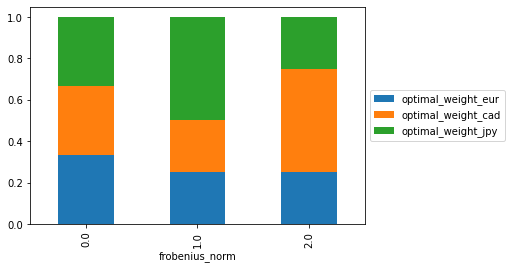

In [173]:
ax = qfunction.set_index('frobenius_norm').plot(kind='bar',stacked=True)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.savefig('RL-specifichour_'+str(weightOptions)+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

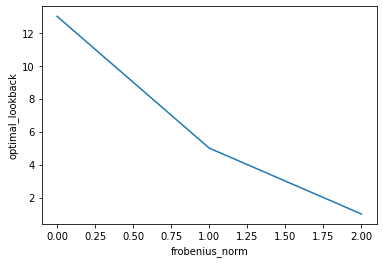

In [138]:
sns.lineplot(data=qfunction, x='frobenius_norm', y='optimal_lookback')
plt.show()

In [139]:
backtest_return = pd.DataFrame()
for i in range(len(frob_backtest)-1):
    curr = State(frob_backtest.loc[frob_backtest.index[i]][0])
    optimal_lookback = learner.greedy_action(curr).lookback

    prev_df = minute_df_usd_price_est[(minute_df_usd_price_est.index <= frob_backtest.index[i])]
    lookback_df = prev_df.iloc[-optimal_lookback*23*60:]
    w = markowitz_weight(lookback_df)

    backtest_df = ret_df[(ret_df.index <= frob_backtest.index[i+1]) & (ret_df.index > frob_backtest.index[i])]

    backtest_performance = w*backtest_df
    backtest_port = backtest_performance.sum(axis=1)
    backtest_return = backtest_return.append(pd.DataFrame(backtest_port))

backtest_return.std()*np.sqrt(23*60*252)

0    0.095752
dtype: float64

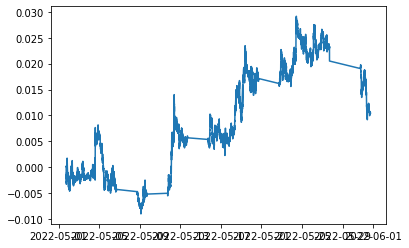

In [140]:
plt.plot((1+backtest_return).cumprod() -1)